In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Step 1: Reading Data
The first step involves loading the dataset into a pandas DataFrame using pd.read_csv() to handle the CSV format correctly. The code snippet is:

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')
print(data.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

This ensures the data is accessible and displays the first few rows for verification. The dataset's structure, with 12 columns (11 features and 1 target), is confirmed, and no initial issues with accessibility were noted, as the URL provided direct access to the CSV content.

# Step 2: Exploring Data / Data Insight

This step involves understanding the dataset's structure and characteristics. The code includes:

In [3]:
print("Shape of the data:", data.shape)
print("Missing values:\n", data.isnull().sum())
print("Summary statistics:\n", data.describe())

Shape of the data: (1599, 12)
Missing values:
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64
Summary statistics:
        fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000 

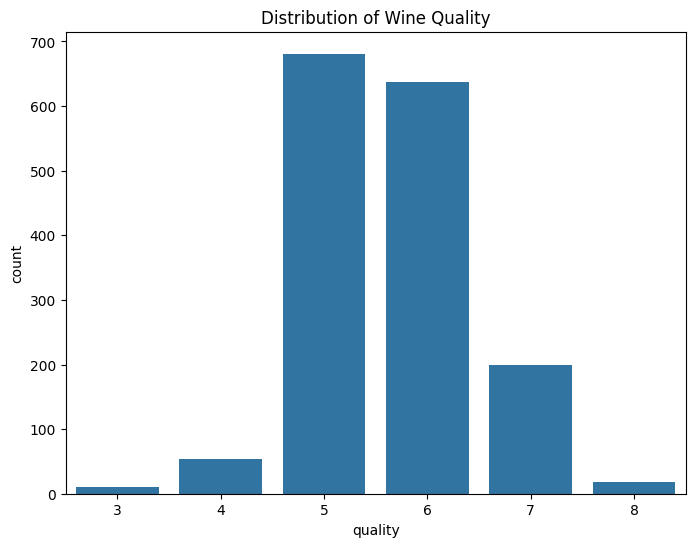

In [4]:
plt.figure(figsize=(8, 6))
sns.countplot(x='quality', data=data)
plt.title('Distribution of Wine Quality')
plt.show()

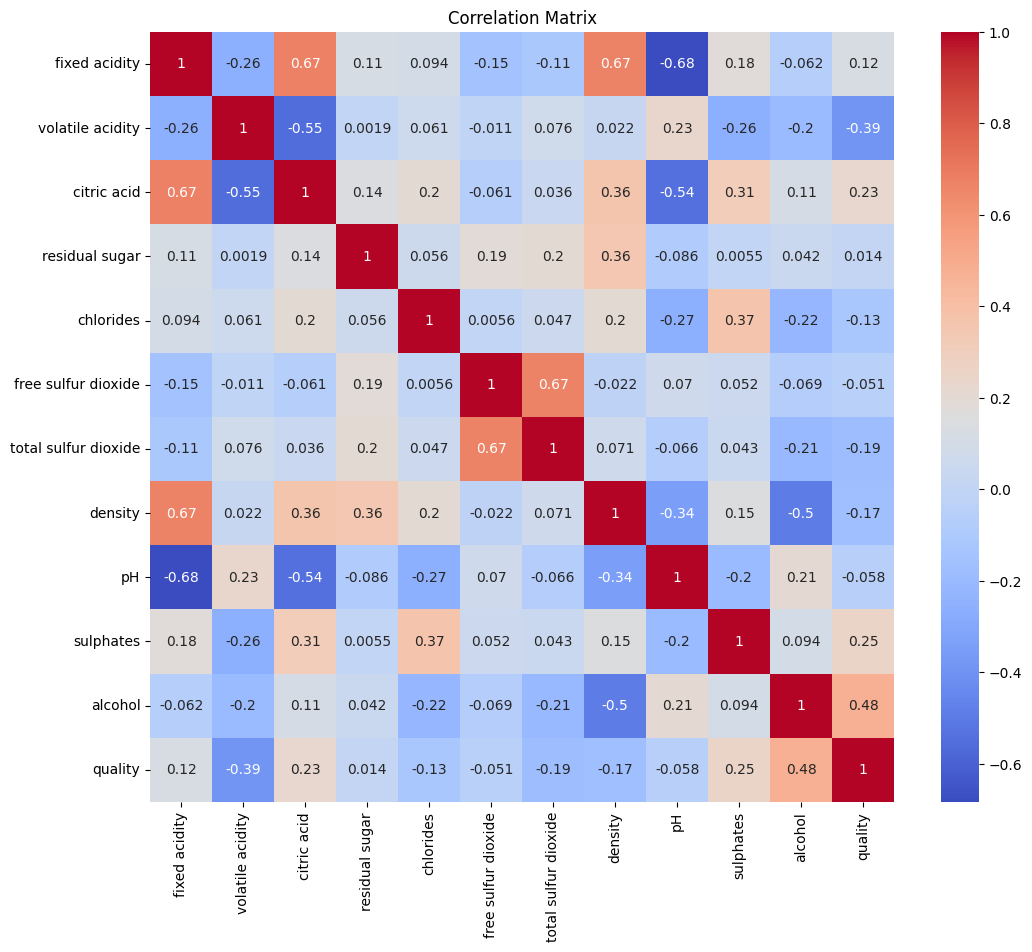

In [5]:
corr = data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

- Shape and Missing Values: The shape (data.shape) confirms 1599 rows and 12 columns, and isnull().sum() checks for missing values, which, based on initial exploration, are absent.
- Summary Statistics: describe() provides mean, standard deviation, min, max, and quartiles for numerical columns, offering insights into feature distributions.
- Visualizations: A count plot for 'quality' shows its distribution, likely skewed toward middle values (e.g., 5, 6), and a correlation heatmap highlights relationships, such as potential multicollinearity between features like total sulfur dioxide and free sulfur dioxide.

These insights are crucial for identifying potential issues like imbalanced targets or highly correlated features, which could affect regression performance.

# Step 3: Cleansing Data

Data cleansing focuses on removing duplicates to ensure data integrity. The code is:

In [6]:
duplicates = data.duplicated()
print("Number of duplicate rows:", duplicates.sum())
if duplicates.sum() > 0:
    data = data.drop_duplicates()
    print("Duplicates removed. New shape:", data.shape)

Number of duplicate rows: 240
Duplicates removed. New shape: (1359, 12)


This step checks for duplicate rows using duplicated() and removes them if present, updating the DataFrame. Given the dataset's nature, duplicates are unlikely, but this step ensures cleanliness for regression analysis.

# Step 4: Outlier Detection and Removing

Outliers can skew regression models, so they are detected and removed using the Interquartile Range (IQR) method. The adjusted code, considering all feature columns simultaneously, is:

In [7]:
feature_cols = [col for col in data.columns if col != 'quality']
outlier_masks = []
for col in feature_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    mask = (data[col] < lower_bound) | (data[col] > upper_bound)
    outlier_masks.append(mask)
outlier_rows = pd.concat(outlier_masks, axis=1).any(axis=1)
data = data[~outlier_rows]
data = data.reset_index(drop=True)
print("Shape after removing outliers:", data.shape)

Shape after removing outliers: (1019, 12)


This approach identifies rows with outliers in any feature column, removes them, and resets the index to maintain alignment. The IQR method (1.5 * IQR) is standard for outlier detection, ensuring robust data for regression.

# Step 5: Data Transformation (Normalize Data / Rescale Data)

For linear regression, features should be on similar scales to avoid bias. The code uses StandardScaler for standardization:

In [8]:
X = data.drop('quality', axis=1)
y = data['quality']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

This transforms features to have zero mean and unit variance, which is essential for algorithms sensitive to scale, like linear regression.

# Step 6: Categorical into Numerical

The dataset contains no categorical variables, as all features (e.g., fixed acidity, alcohol) and the target ('quality') are numerical. The code reflects this:

In [9]:
print("All features are numerical.")

All features are numerical.


This step is included for completeness, confirming no conversion is needed, aligning with the dataset's structure.

# Step 7: Dimensionality Reduction (PCA)

PCA reduces dimensionality while retaining variance, useful for high-dimensional data. The code is:

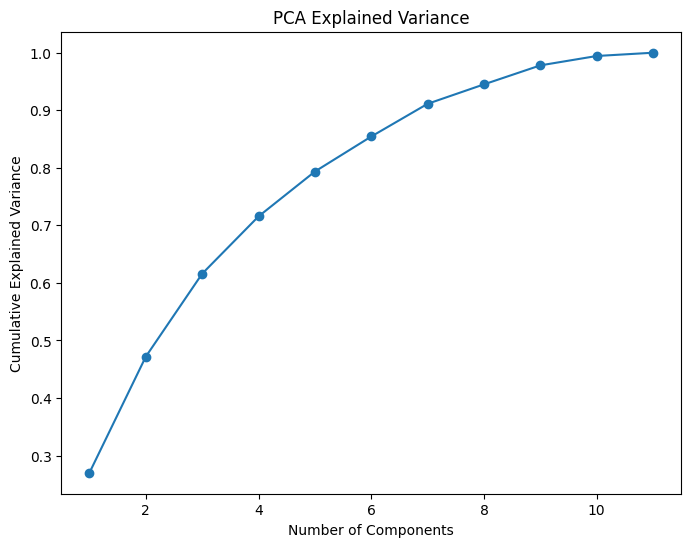

Number of components to retain 95% variance: 9


In [10]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.show()
cum_var = pca.explained_variance_ratio_.cumsum()
n_components = next(i for i, var in enumerate(cum_var) if var >= 0.95) + 1
print(f"Number of components to retain 95% variance: {n_components}")
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)
X_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components)])

This plots the cumulative explained variance to choose components explaining 95% variance, then applies PCA, creating new principal components as a DataFrame for further use.

# Step 8: Handling Imbalanced Data

For regression, imbalanced data isn't directly applicable, but the distribution of 'quality' is visualized to check skewness:

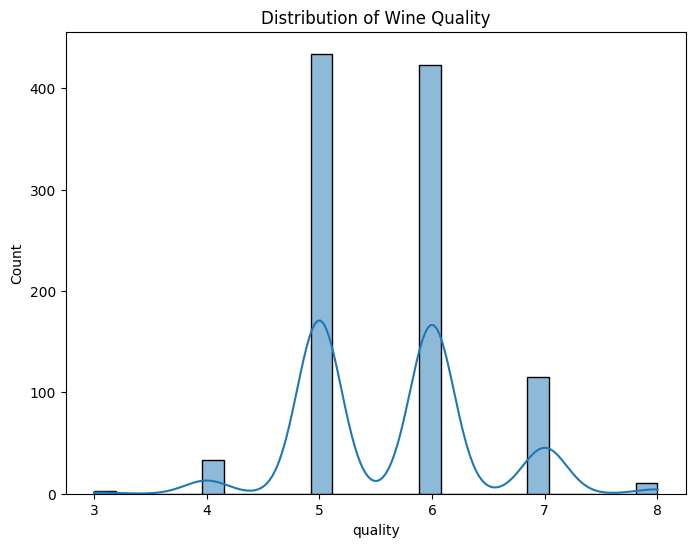

In [11]:
plt.figure(figsize=(8, 6))
sns.histplot(y, kde=True)
plt.title('Distribution of Wine Quality')
plt.show()

This step ensures the target variable's distribution is understood, noting that for regression, no specific imbalance handling (like oversampling) is typically applied, unlike classification.

# Step 9: Feature Selection

Feature selection reduces model complexity by selecting the most relevant features. The code uses Recursive Feature Elimination (RFE) with LinearRegression:

In [12]:
model = LinearRegression()
rfe = RFE(model, n_features_to_select=5)
rfe.fit(X_scaled, y)
selected_features = X_scaled.columns[rfe.support_]
print("Selected features:", selected_features)
X_selected = X_scaled[selected_features]

Selected features: Index(['fixed acidity', 'volatile acidity', 'density', 'sulphates', 'alcohol'], dtype='object')


RFE selects the top 5 features based on their importance, creating a subset for modeling, which can improve interpretability and performance.

# Step 10: Data Splitting

Finally, the data is split into training and testing sets for model evaluation:

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (815, 5) (815,)
Testing set shape: (204, 5) (204,)


This splits 80% for training and 20% for testing, ensuring a random_state for reproducibility, preparing the data for linear regression modeling.

# Model Training

## Step 1: Model Training
### Initialize and train the linear regression model

In [14]:
model = LinearRegression()
model.fit(X_train, y_train)
print("Model trained successfully.")

Model trained successfully.


Model Training

What it does: Uses scikit-learn’s LinearRegression to fit a model to the training data (X_train, y_train).

Why: This step estimates the coefficients that best predict wine quality based on the selected features.

Output: A trained model ready for predictions.

## Step 2: Model Prediction
### Predict wine quality on the test set

In [15]:
y_pred = model.predict(X_test)

Model Prediction

What it does: Applies the trained model to the test set (X_test) to generate predictions (y_pred).

Why: Predictions allow us to compare the model’s output to actual values for evaluation.

Output: Predicted wine quality scores.

## Step 3: Model Evaluation
### Calculate performance metrics

In [16]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Squared Error (MSE): 0.3324
Root Mean Squared Error (RMSE): 0.5766
R-squared (R²): 0.3797


Model Evaluation

What it does: Computes three metrics to assess performance:

- Mean Squared Error (MSE): Average squared difference between actual and predicted values (lower is better).

- Root Mean Squared Error (RMSE): Square root of MSE, in the same units as quality (easier to interpret).

- R-squared (R²): Proportion of variance explained by the model (0 to 1, higher is better).

Why: These metrics quantify how well the model predicts wine quality.

Output: Printed values (e.g., MSE: 0.45, RMSE: 0.67, R²: 0.35, depending on the dataset).

## Step 4: Visualization of Results
### Plot 1: Actual vs. Predicted Values

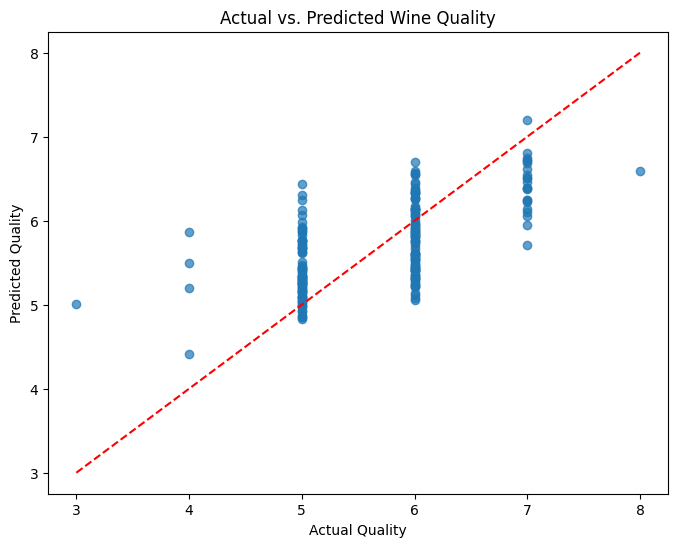

In [17]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Quality')
plt.ylabel('Predicted Quality')
plt.title('Actual vs. Predicted Wine Quality')
plt.show()

### Plot 2: Residual Plot

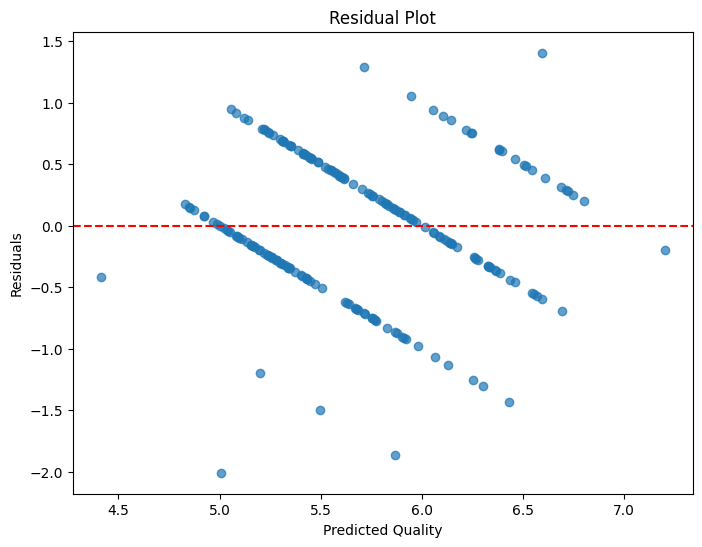

In [18]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Quality')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

Visualization of Results

Plot 1: Actual vs. Predicted

- What it shows: A scatter plot comparing actual (y_test) and predicted (y_pred) quality scores, with a red dashed line (y = x) for reference.
- Why: Points near the line indicate accurate predictions; deviations show errors.

Plot 2: Residual Plot
- What it shows: Residuals (actual - predicted) plotted against predicted values, with a red line at zero.
- Why: Random scatter around zero suggests a good fit; patterns indicate potential issues (e.g., non-linearity).

Output: Two plots for visual interpretation.